<a href="https://colab.research.google.com/github/kevin-r-murphy/BA888-MBTA/blob/main/MBTA_Bus_29%26245.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [89]:
import datetime as dt
import seaborn as sns
import matplotlib.pyplot as plt

In [90]:
import pandas as pd
import numpy as np
#trips = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/trips.txt')
#shapes = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/shapes.txt')
#stop_times = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/stop_times.txt')
stops = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/stops.txt')
#route_patterns = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/route_patterns.txt')
route = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/routes.txt')
#jan_headway = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/2024-01_Headway.csv')
#feb_headway = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/2024-02_Headway.csv')
#gated_entries = pd.read_csv('https://raw.githubusercontent.com/kevin-r-murphy/BA888-MBTA/main/MBTA_Gated_Station_Entries.csv')
#headways = pd.concat([jan_headway, feb_headway])

In [91]:
!pip install requests
import requests
import zipfile
from zipfile import ZipFile
import os, os.path

In [92]:
url = 'https://www.arcgis.com/sharing/rest/content/items/96c77138c3144906bce93d0257531b6a/data'
response = requests.get(url)
with open('Bus.zip', 'wb') as f:
    f.write(response.content)

with ZipFile('Bus.zip', 'r') as f:
    f.extractall()

In [93]:
bus_headways = pd.read_csv('/content/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-01.csv')
path = '/content/MBTA_Bus_Arrival_Departure_Times_2024'
num_files = len([f for f in os.listdir(path)
                if os.path.isfile(os.path.join(path, f))])
for i in range(2, num_files+1):
  df = pd.read_csv(f'/content/MBTA_Bus_Arrival_Departure_Times_2024/MBTA-Bus-Arrival-Departure-Times_2024-'+ str(i).zfill(2) + '.csv')
  bus_headways = pd.concat([bus_headways, df])

****Bus Data****

In [94]:
td = dt.timedelta(days=1)
bus_headways = bus_headways[bus_headways['scheduled'] != '1900-01-01']
bus_headways['scheduled'] = bus_headways['scheduled'].astype(str).apply(lambda x: x.split('T')[1].replace('Z','') if pd.notna(x) and 'T' in x else x)
bus_headways['scheduled'] = pd.to_datetime(bus_headways['scheduled'], format = "%H:%M:%S")
bus_headways['actual'] = bus_headways['actual'].astype(str).apply(lambda x: x.split('T')[1].replace('Z','') if pd.notna(x) and 'T' in x else x)
bus_headways['actual'] = pd.to_datetime(bus_headways['actual'], format = "%H:%M:%S")
bus_headways['actual'] = bus_headways['actual'].apply(lambda x: x + td if x < pd.Timestamp('1900-01-01 02:30:00') else x)
bus_headways['scheduled'] = bus_headways['scheduled'].apply(lambda x: x + td if x < pd.Timestamp('1900-01-01 02:30:00') else x)
bus_headways['time_diff'] = abs((bus_headways['actual'] - bus_headways['scheduled']).dt.total_seconds()) / 60
bus_headways['headway_diff'] = (bus_headways['headway'] - bus_headways['scheduled_headway']) / 60
bus_headways = bus_headways[bus_headways['time_diff'] < 1200]
bus_headways['half_trip_id'] = bus_headways['half_trip_id'].astype(str).apply(lambda x: x.split('.')[0])
bus_headways['scheduled_time'] = bus_headways['scheduled'].dt.time
bus_headways.head()

,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway,time_diff,headway_diff,scheduled_time
0,2024-01-01,01,Inbound,61824022,110,hhgat,1,Startpoint,Schedule,1900-01-01 06:05:00,1900-01-01 06:05:03,NaN,NaN,0.050000,NaN,06:05:00
1,2024-01-01,01,Inbound,61824022,67,maput,2,Midpoint,Schedule,1900-01-01 06:09:00,1900-01-01 06:08:17,NaN,NaN,0.716667,NaN,06:09:00
2,2024-01-01,01,Inbound,61824022,72,cntsq,3,Midpoint,Schedule,1900-01-01 06:12:00,1900-01-01 06:12:00,NaN,NaN,0.000000,NaN,06:12:00
3,2024-01-01,01,Inbound,61824022,75,mit,4,Midpoint,Schedule,1900-01-01 06:15:00,1900-01-01 06:16:50,NaN,NaN,1.833333,NaN,06:15:00
4,2024-01-01,01,Inbound,61824022,79,hynes,5,Midpoint,Schedule,1900-01-01 06:19:00,1900-01-01 06:20:45,NaN,NaN,1.750000,NaN,06:19:00


In [95]:
bus_headways['stop_id'] = bus_headways['stop_id'].astype(str)
bus_headways_stop = bus_headways.merge(stops[['stop_id','stop_name', 'stop_lat', 'stop_lon']], left_on = 'stop_id', right_on = 'stop_id', how = 'left')
bus_headways_stop = bus_headways_stop[bus_headways_stop['scheduled'] != '1899-12-31']
bus_standard_schedule = bus_headways_stop[bus_headways_stop['standard_type'] == 'Schedule']

bus_standard_schedule.head()
print(bus_standard_schedule.shape)
del bus_headways

(6792585, 19)


***Bus - Schedule***

In [96]:
bus_standard_schedule.head()

,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway,time_diff,headway_diff,scheduled_time,stop_name,stop_lat,stop_lon
0,2024-01-01,01,Inbound,61824022,110,hhgat,1,Startpoint,Schedule,1900-01-01 06:05:00,1900-01-01 06:05:03,NaN,NaN,0.050000,NaN,06:05:00,Massachusetts Ave @ Holyoke St,42.373111,-71.117653
1,2024-01-01,01,Inbound,61824022,67,maput,2,Midpoint,Schedule,1900-01-01 06:09:00,1900-01-01 06:08:17,NaN,NaN,0.716667,NaN,06:09:00,Mt Auburn St @ Putnam Ave,42.370044,-71.113514
2,2024-01-01,01,Inbound,61824022,72,cntsq,3,Midpoint,Schedule,1900-01-01 06:12:00,1900-01-01 06:12:00,NaN,NaN,0.000000,NaN,06:12:00,Massachusetts Ave @ Pearl St,42.364915,-71.103074
3,2024-01-01,01,Inbound,61824022,75,mit,4,Midpoint,Schedule,1900-01-01 06:15:00,1900-01-01 06:16:50,NaN,NaN,1.833333,NaN,06:15:00,84 Massachusetts Ave,42.358673,-71.093551
4,2024-01-01,01,Inbound,61824022,79,hynes,5,Midpoint,Schedule,1900-01-01 06:19:00,1900-01-01 06:20:45,NaN,NaN,1.750000,NaN,06:19:00,Massachusetts Ave @ Boylston St,42.346965,-71.087720


**Aggregated DataFrames for Scheduled Bus**

In [97]:
#Creating Aggregated Dataframes for enhanced views
bus_schedule_station = bus_standard_schedule.groupby(['stop_id','direction_id', 'stop_name', 'stop_lat', 'stop_lon'])['time_diff'].agg(['mean','median', 'std', 'max', 'min','count']).reset_index()
bus_schedule_station = bus_schedule_station.sort_values(by = 'median', ascending = False)
bus_schedule_station['stop_title'] = bus_schedule_station['stop_name'] + ' ' + bus_schedule_station['direction_id'].astype(str)
bus_schedule_station= bus_schedule_station[bus_schedule_station['count'] > 20]
bus_schedule_station.head()


,stop_id,direction_id,stop_name,stop_lat,stop_lon,mean,median,std,max,min,count,stop_title
982,5862,Outbound,Opp 345 Maverick St,42.366524,-71.030532,28.741304,29.350000,10.161993,46.766667,4.366667,23,Opp 345 Maverick St Outbound
969,57400,Outbound,Maverick,42.369070,-71.039473,27.013426,27.408333,11.286567,49.983333,0.350000,36,Maverick Outbound
341,20,Inbound,Dorchester St @ E Broadway,42.335377,-71.045728,12.266517,12.433333,5.764770,29.800000,0.450000,111,Dorchester St @ E Broadway Inbound
2,10006,Inbound,Albany St opp E Newton St,42.335814,-71.070135,14.620320,12.416667,11.218661,326.366667,0.000000,6232,Albany St opp E Newton St Inbound
283,1780,Inbound,Longwood Ave @ Blackfan St,42.337436,-71.104448,14.175577,12.400000,9.303878,87.533333,0.066667,2645,Longwood Ave @ Blackfan St Inbound


Text(0.5, 0, 'Median Departure Difference (Minutes)')

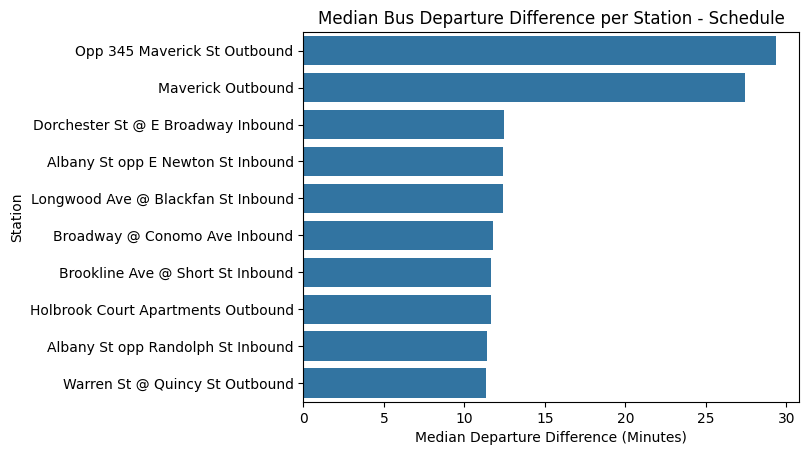

In [98]:
sns.barplot(data = bus_schedule_station.head(10), x = 'median', y = 'stop_title', orient = 'h')
plt.title('Median Bus Departure Difference per Station - Schedule')
plt.ylabel('Station')
plt.xlabel('Median Departure Difference (Minutes)')

In [99]:
import plotly.express as px
from plotly.offline import plot
px.set_mapbox_access_token('pk.eyJ1Ijoia2VtdTEiLCJhIjoiY2x5YWYzeDZtMTNwdzJybXhsMnhiOHFlcCJ9.ZlVG4dJl_SlRlFhYPmQdsw')
fig = px.scatter_mapbox(bus_schedule_station.head(100), lat="stop_lat", lon="stop_lon",
                        zoom=10,
                        size = 'median',
                        #color_continuous_scale=px.colors.sequential.amp,
                        color="direction_id",
                        mapbox_style = 'basic',
                        title = 'Median Bus Departure Difference per Station - Schedule',
                        labels = {'median':'Median Departure Difference (Minutes)',
                                  'direction_id': 'Direction',
                                  'stop_name': 'Stop'},
                        hover_data = ['direction_id', 'stop_name'],

                        #symbol = 'direction_id',

                        width = 1000,
                        height = 800
)
fig.update_layout(
    title_x=0.5,
    title_y=0.9,
    title_font_size=24,
    legend_x = 0,
    legend_y = 1
)

fig.show()

In [100]:
bus_schedule_route = bus_standard_schedule.groupby(['route_id', 'direction_id'])['time_diff'].agg(['mean', 'median','std', 'max', 'min','count']).reset_index()
bus_schedule_route['route_name'] = bus_schedule_route['route_id'] + ' ' + bus_schedule_route['direction_id'].astype(str)
bus_schedule_route = bus_schedule_route.merge(route[['route_id', 'route_long_name', 'route_desc']])
bus_schedule_route = bus_schedule_route.sort_values(by = 'median', ascending = False)
bus_schedule_route.head()

,route_id,direction_id,mean,median,std,max,min,count,route_name,route_long_name,route_desc
173,47,Inbound,10.958036,8.233333,10.585401,331.100000,0.0,48106,47 Inbound,"Central Square, Cambridge - Broadway Station",Local Bus
101,29,Inbound,10.314449,7.716667,8.628204,83.466667,0.0,25632,29 Inbound,Mattapan Station - Jackson Square Station,Local Bus
96,245,Outbound,10.605902,7.583333,10.159615,66.283333,0.0,4744,245 Outbound,Quincy Center Station - Mattapan Station,Local Bus
140,424,Outbound,8.468626,7.283333,6.475482,56.616667,0.0,4390,424 Outbound,Eastern Avenue & Essex Street - Wonderland Sta...,Commuter Bus
102,29,Outbound,9.969110,7.166667,9.205833,73.366667,0.0,23962,29 Outbound,Mattapan Station - Jackson Square Station,Local Bus


Text(0.5, 0, 'Median Departure Difference (Minutes)')

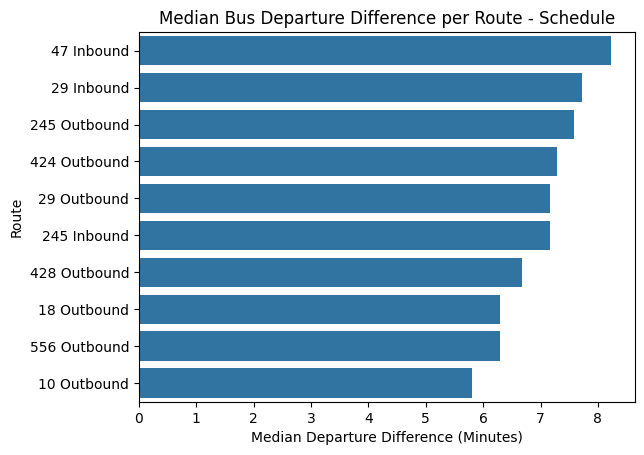

In [101]:
sns.barplot(data = bus_schedule_route.head(10), x = 'median', y = 'route_name', orient = 'h')
plt.title('Median Bus Departure Difference per Route - Schedule')
plt.ylabel('Route')
plt.xlabel('Median Departure Difference (Minutes)')

In [102]:
bus_schedule_route_stop = bus_standard_schedule.groupby(['route_id', 'direction_id', 'stop_id', 'stop_name', 'stop_lat', 'stop_lon'])['time_diff'].agg(['mean','median', 'std', 'max', 'min','count']).reset_index()
bus_schedule_route_stop = bus_schedule_route_stop.sort_values(by = 'median', ascending = False)
bus_schedule_route_stop['route_name'] = 'Route: ' + bus_schedule_route_stop['route_id'] + ' ' + bus_schedule_route_stop['direction_id'].astype(str) + ' At ' + bus_schedule_route_stop['stop_name']
bus_schedule_route_stop.head()

,route_id,direction_id,stop_id,stop_name,stop_lat,stop_lon,mean,median,std,max,min,count,route_name
678,210,Outbound,38671,Braintree,42.207213,-71.001278,53.966667,53.966667,NaN,53.966667,53.966667,1,Route: 210 Outbound At Braintree
679,210,Outbound,41031,Quincy Adams,42.233238,-71.007244,49.466667,49.466667,NaN,49.466667,49.466667,1,Route: 210 Outbound At Quincy Adams
1611,45,Outbound,334,Ashmont,42.284195,-71.063879,31.270303,31.033333,8.676351,54.350000,14.200000,110,Route: 45 Outbound At Ashmont
1614,45,Outbound,426,Talbot Ave @ Lithgow St,42.289943,-71.069975,31.224943,30.716667,8.065374,52.566667,14.566667,147,Route: 45 Outbound At Talbot Ave @ Lithgow St
1612,45,Outbound,415,Blue Hill Ave @ Franklin Park Rd,42.303293,-71.085370,30.971581,30.583333,9.090911,60.700000,12.350000,156,Route: 45 Outbound At Blue Hill Ave @ Franklin...


Text(0.5, 0, 'Median Departure Difference (Minutes)')

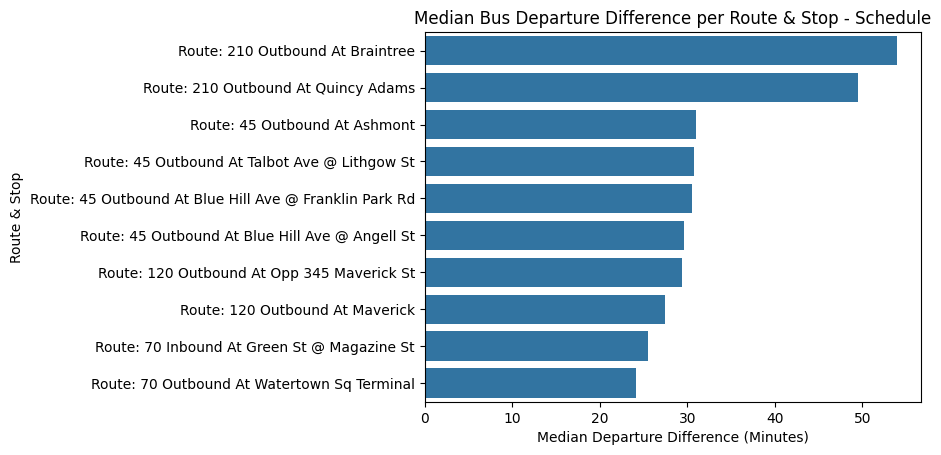

In [103]:
sns.barplot(data = bus_schedule_route_stop.head(10), x = 'median', y = 'route_name', orient = 'h')
plt.title('Median Bus Departure Difference per Route & Stop - Schedule')
plt.ylabel('Route & Stop')
plt.xlabel('Median Departure Difference (Minutes)')

In [104]:
fig = px.scatter_mapbox(bus_schedule_route_stop.head(100), lat="stop_lat", lon="stop_lon",
                        zoom=10,
                        size = 'median',
                        #color_continuous_scale=px.colors.sequential.amp,
                        color="direction_id",
                        mapbox_style = 'basic',
                        title = 'Median Bus Departure Difference per Station & Route - Schedule',
                        labels = {'median':'Median Departure Difference (Minutes)',
                                  'direction_id': 'Direction',
                                  'stop_name': 'Stop',
                                  'route_id': 'Route'},
                        hover_data = ['direction_id', 'stop_name', 'route_id'],

                        #symbol = 'direction_id',

                        width = 1000,
                        height = 800
)
fig.update_layout(
    title_x=0.5,
    title_y=0.9,
    title_font_size=24,
    legend_x = 0,
    legend_y = 1
)
fig.write_html('bus_schedule_route_stop.html')
fig.show()

In [105]:
bus_schedule_date = bus_standard_schedule.groupby(['service_date', 'direction_id'])['time_diff'].agg(['mean','median', 'std', 'max', 'min','count']).reset_index()
#bus_schedule_date = bus_schedule_date.sort_values(by = 'median', ascending = False)
bus_schedule_date['date_name'] = bus_schedule_date['service_date'] + ' ' + bus_schedule_date['direction_id'].astype(str)
bus_schedule_date.head()

,service_date,direction_id,mean,median,std,max,min,count,date_name
0,2024-01-01,Inbound,3.062880,2.000000,3.598392,62.283333,0.0,9577,2024-01-01 Inbound
1,2024-01-01,Outbound,3.378373,2.183333,4.134117,52.233333,0.0,9610,2024-01-01 Outbound
2,2024-01-02,Inbound,3.693683,2.516667,4.016257,60.766667,0.0,21736,2024-01-02 Inbound
3,2024-01-02,Outbound,4.063184,2.733333,4.503188,47.000000,0.0,21673,2024-01-02 Outbound
4,2024-01-03,Inbound,4.216877,2.833333,4.610958,49.233333,0.0,21909,2024-01-03 Inbound


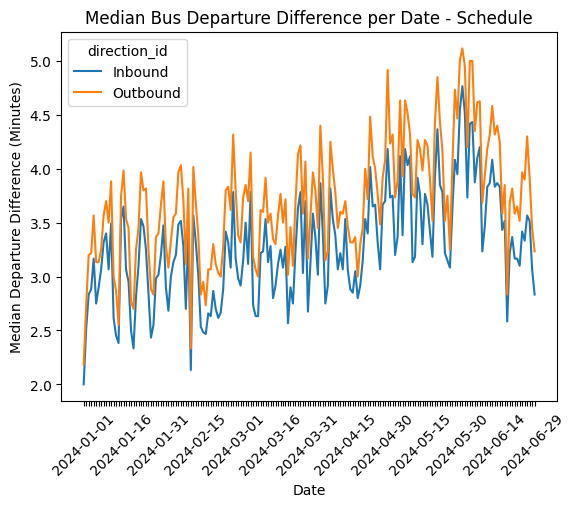

In [106]:
plot = sns.lineplot(data = bus_schedule_date, y = 'median', x = 'service_date', hue = 'direction_id')
plt.title('Median Bus Departure Difference per Date - Schedule')
plt.xlabel('Date')
plt.ylabel('Median Departure Difference (Minutes)')
plt.xticks(rotation = 45)
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 15 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

**Fourier Transform**

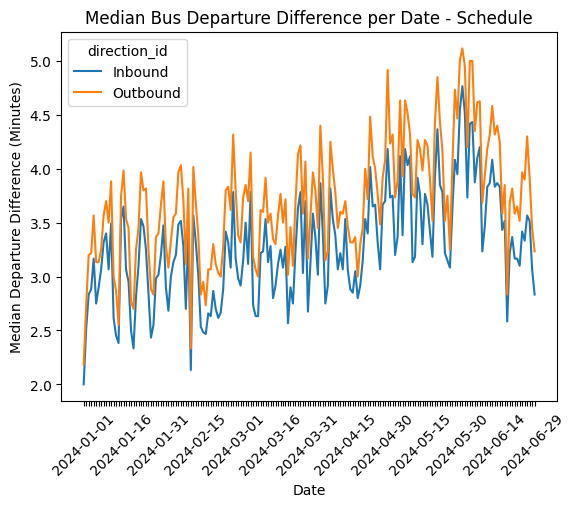

In [107]:
plot = sns.lineplot(data = bus_schedule_date, y = 'median', x = 'service_date', hue = 'direction_id')
plt.title('Median Bus Departure Difference per Date - Schedule')
plt.xlabel('Date')
plt.ylabel('Median Departure Difference (Minutes)')
plt.xticks(rotation = 45)
for ind, label in enumerate(plot.get_xticklabels()):
    if ind % 15 == 0:
        label.set_visible(True)
    else:
        label.set_visible(False)

In [108]:
bus_schedule_date['service_date'] = pd.to_datetime(bus_schedule_date['service_date'])
bus_schedule_date = bus_schedule_date.set_index('service_date')

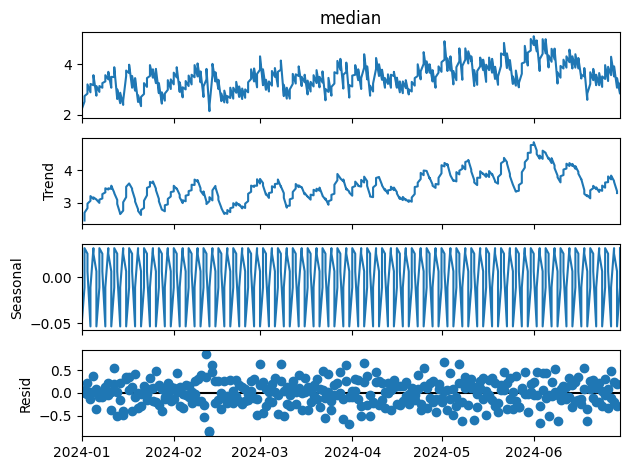

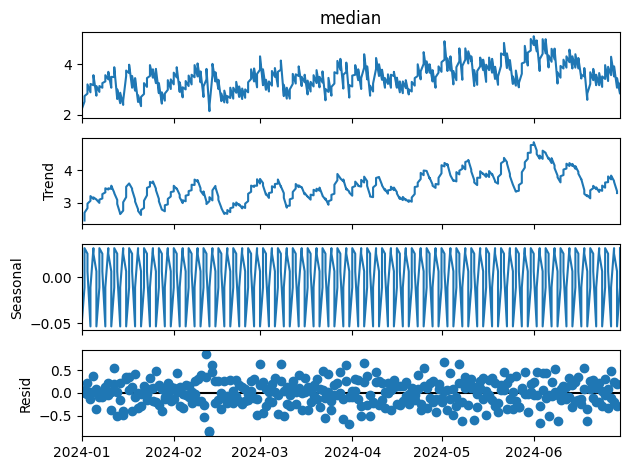

In [109]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomp = seasonal_decompose(bus_schedule_date['median'], model='additive', period = 5)

decomp.plot()


****Route Investigations****

***Route 29***

In [110]:
bus_schedule_route_29 = bus_schedule_route[bus_schedule_route['route_id'] == '29']
bus_schedule_stop_29 = bus_schedule_route_stop[bus_schedule_route_stop['route_id'] == '29']
bus_schedule_route_29.head()


,route_id,direction_id,mean,median,std,max,min,count,route_name,route_long_name,route_desc
101,29,Inbound,10.314449,7.716667,8.628204,83.466667,0.0,25632,29 Inbound,Mattapan Station - Jackson Square Station,Local Bus
102,29,Outbound,9.969110,7.166667,9.205833,73.366667,0.0,23962,29 Outbound,Mattapan Station - Jackson Square Station,Local Bus


In [111]:
bus_29 = bus_standard_schedule[bus_standard_schedule['route_id'] == '29']
ames_id = bus_29[bus_29['stop_id'] == '11735']['half_trip_id'].values
bus_29['has_ames'] = bus_29['half_trip_id'].apply(lambda x: 1 if x in ames_id else 0)
bus_29 = bus_29[(bus_29['has_ames'] == 1) | ((bus_29['has_ames'] == 0) & (bus_29['time_point_order'] < 9))]
bus_29_fullride = bus_29.groupby('half_trip_id')['time_diff'].count().to_frame().reset_index()
bus_29_fullride = bus_29_fullride[bus_29_fullride['time_diff'] > 7]
bus_29 = bus_29[bus_29['half_trip_id'].isin(bus_29_fullride['half_trip_id'])]

<ipython-input-111-3174b5595f8d>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0.5, 1.0, 'Mean Bus Departure Difference per Direction - Route 29')

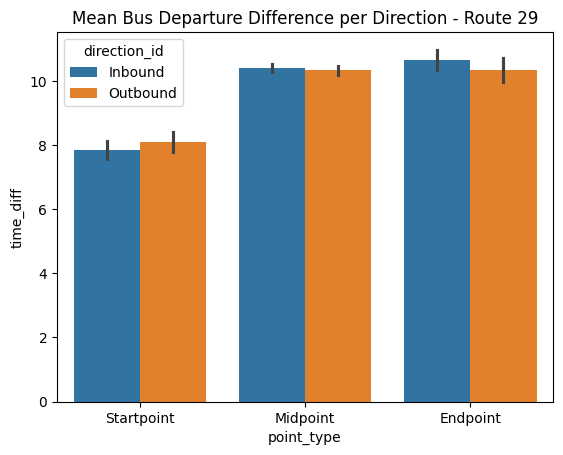

In [112]:
sns.barplot(data = bus_29, y = 'time_diff', x = 'point_type', hue = 'direction_id')
plt.title('Mean Bus Departure Difference per Direction - Route 29')

Text(0.5, 0, 'Stop Number')

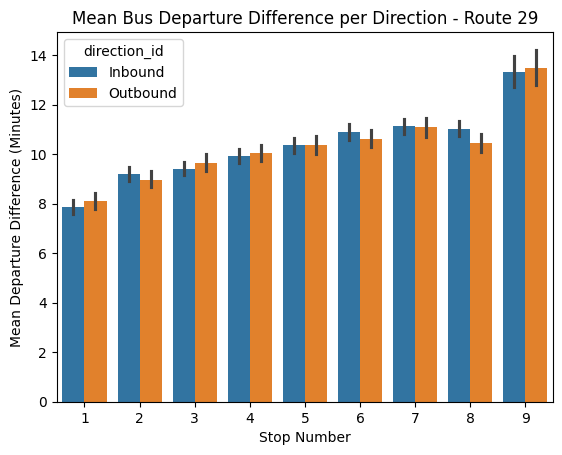

In [113]:
sns.barplot(data = bus_29, y = 'time_diff', x = 'time_point_order', hue = 'direction_id')
plt.title('Mean Bus Departure Difference per Direction - Route 29')
plt.ylabel('Mean Departure Difference (Minutes)')
plt.xlabel('Stop Number')

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13],
 [Text(0, 0, 'Columbus Ave @ Weld Ave - Egleston Sq'),
  Text(1, 0, 'Jackson Square'),
  Text(2, 0, 'Blue Hill Ave @ Morton St'),
  Text(3, 0, 'Ames St @ Franklin Field'),
  Text(4, 0, 'Columbus Ave opp Weld Ave - Egleston Sq'),
  Text(5, 0, 'Blue Hill Ave @ Wellington Hill St'),
  Text(6, 0, 'Blue Hill Ave @ Fessenden St'),
  Text(7, 0, 'Blue Hill Ave @ Harvard St'),
  Text(8, 0, 'Seaver St opp Maple St'),
  Text(9, 0, 'Seaver St @ Humboldt Ave'),
  Text(10, 0, 'Seaver St opp Humboldt Ave'),
  Text(11, 0, 'Mattapan'),
  Text(12, 0, 'Blue Hill Ave @ Ellington St'),
  Text(13, 0, 'Blue Hill Ave @ Angell St')])

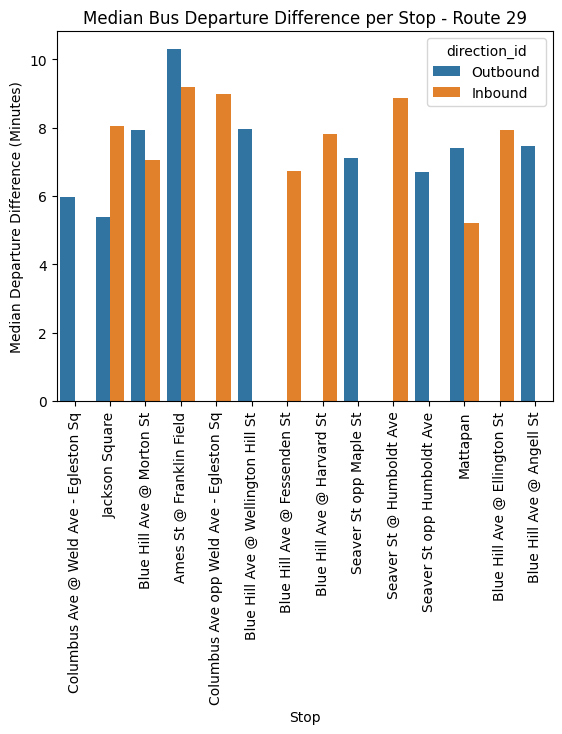

In [114]:
sns.barplot(data = bus_schedule_stop_29.sort_values(by = 'stop_id'), y = 'median', x = 'stop_name', hue = 'direction_id')
plt.title('Median Bus Departure Difference per Stop - Route 29')
plt.ylabel('Median Departure Difference (Minutes)')
plt.xlabel('Stop')
plt.xticks(rotation = 90)

In [115]:
bus_schedule_stop_29['stop_lat'] = np.where(bus_schedule_stop_29['direction_id'] == 'Inbound',
                                    bus_schedule_stop_29['stop_lat'] + 0.001,
                                    bus_schedule_stop_29['stop_lat'] - 0.001)

<ipython-input-115-186b3d91a9dd>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [116]:
fig = px.scatter_mapbox(bus_schedule_stop_29, lat="stop_lat", lon="stop_lon",
                        zoom=12,
                        size = 'median',
                        #color_continuous_scale=px.colors.sequential.amp,
                        color="direction_id",
                        mapbox_style = 'basic',
                        title = 'Median Bus Departure Difference per Station & Route - Headway',
                        labels = {'median':'Median Departure Difference (Minutes)',
                                  'direction_id': 'Direction',
                                  'stop_name': 'Stop',
                                  'route_id': 'Route'},
                        hover_data = ['direction_id', 'stop_name', 'route_id'],

                        #symbol = 'direction_id',

                        width = 1000,
                        height = 800
)
fig.update_layout(
    title_x=0.5,
    title_y=0.9,
    title_font_size=24,
    legend_x = 0,
    legend_y = 1
)

In [117]:
bus_29.groupby(['stop_id', 'stop_name','direction_id'])['time_diff'].count().sort_values(ascending = False)

,,,time_diff
stop_id,stop_name,direction_id,
1731,Blue Hill Ave @ Morton St,Inbound,2952
1741,Seaver St @ Humboldt Ave,Inbound,2952
1728,Blue Hill Ave @ Fessenden St,Inbound,2952
383,Blue Hill Ave @ Ellington St,Inbound,2951
1188,Columbus Ave opp Weld Ave - Egleston Sq,Inbound,2951
1737,Blue Hill Ave @ Harvard St,Inbound,2949
11531,Jackson Square,Inbound,2948
18511,Mattapan,Inbound,2846
17411,Seaver St opp Humboldt Ave,Outbound,2646


(0.0, 14.0)

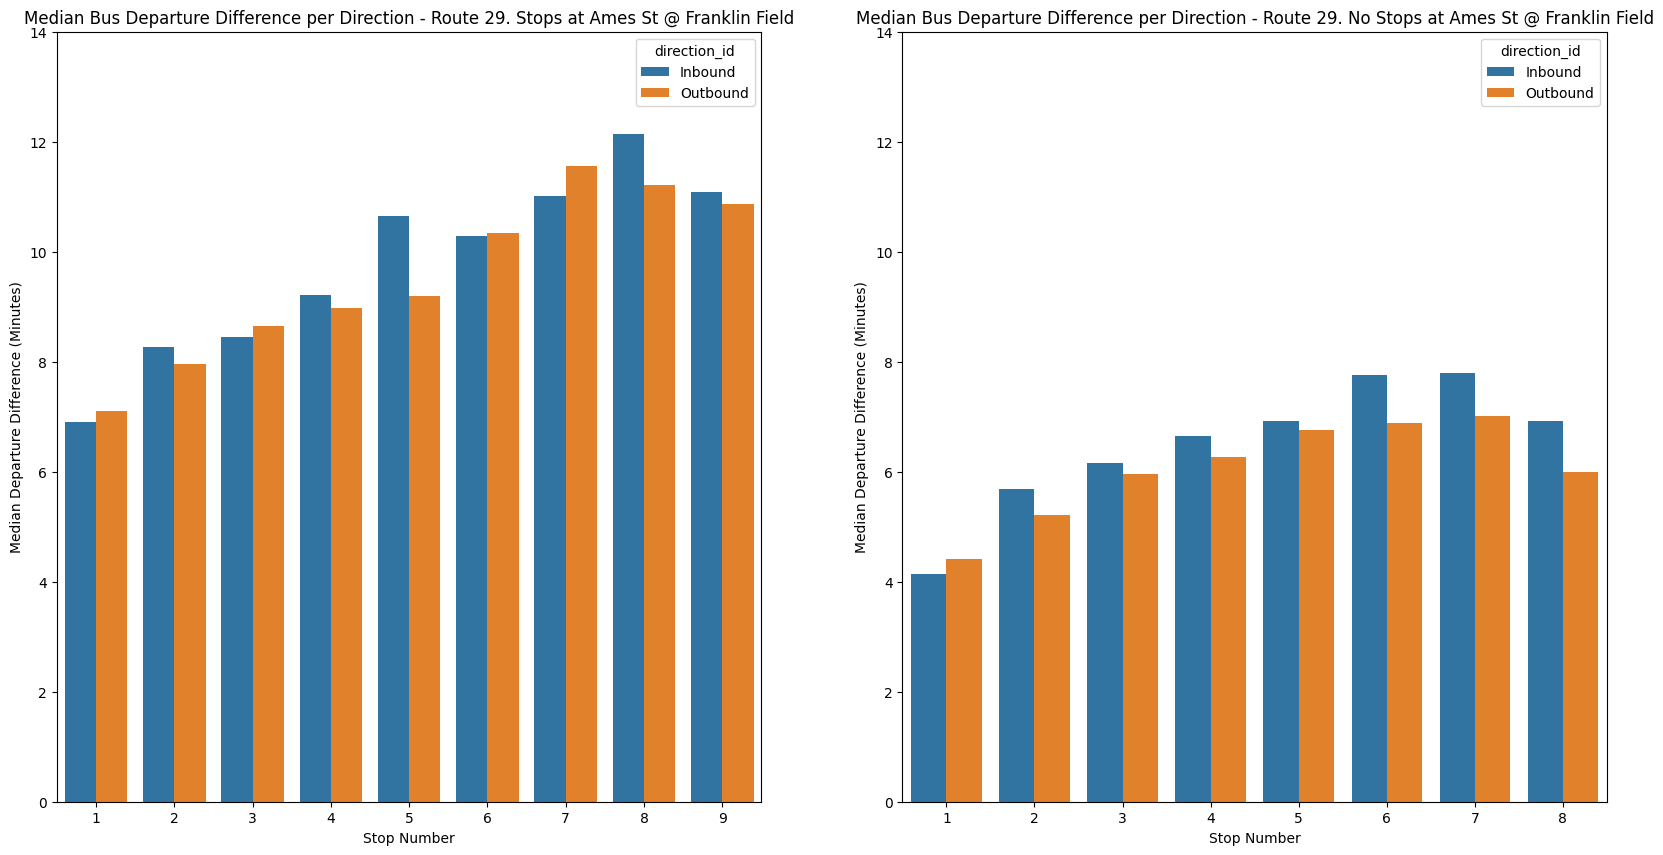

In [118]:
fig,axs = plt.subplots(ncols=2, figsize = (20,10))
sns.barplot(data = bus_29[bus_29['has_ames'] == 1].groupby(['time_point_order', 'direction_id'])['time_diff'].median().to_frame(), x = 'time_point_order', y = 'time_diff', hue = 'direction_id', ax=axs[0])
axs[0].set_title('Median Bus Departure Difference per Direction - Route 29. Stops at Ames St @ Franklin Field')
axs[0].set_ylabel('Median Departure Difference (Minutes)')
axs[0].set_xlabel('Stop Number')
axs[0].set_ylim(0,14)
sns.barplot(data = bus_29[bus_29['has_ames'] == 0].groupby(['time_point_order', 'direction_id'])['time_diff'].median().to_frame(), y = 'time_diff', x = 'time_point_order', hue = 'direction_id', ax=axs[1])
axs[1].set_title('Median Bus Departure Difference per Direction - Route 29. No Stops at Ames St @ Franklin Field')
axs[1].set_ylabel('Median Departure Difference (Minutes)')
axs[1].set_xlabel('Stop Number')
axs[1].set_ylim(0,14)

In [119]:
bus_29[bus_29['point_type'] == 'Startpoint'].groupby(['has_ames', 'scheduled_time'])['time_diff'].count().to_frame().reset_index().sort_values(by = ['scheduled_time'], ascending = False)

,has_ames,scheduled_time,time_diff
38,0,23:54:00,119
37,0,23:35:00,27
36,0,23:29:00,119
35,0,23:07:00,27
34,0,23:05:00,122
33,0,22:41:00,118
32,0,22:35:00,26
31,0,22:13:00,116
30,0,22:07:00,27
29,0,21:48:00,118


In [120]:
bus_29.groupby(['scheduled_time'])['time_diff'].count().sort_values(ascending = False) .head()

,time_diff
scheduled_time,
19:24:00,305
07:20:00,238
07:18:00,238
07:26:00,238
06:47:00,238


<ipython-input-121-0ac6dfcce6bd>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Average Number of Departures (per hour)')

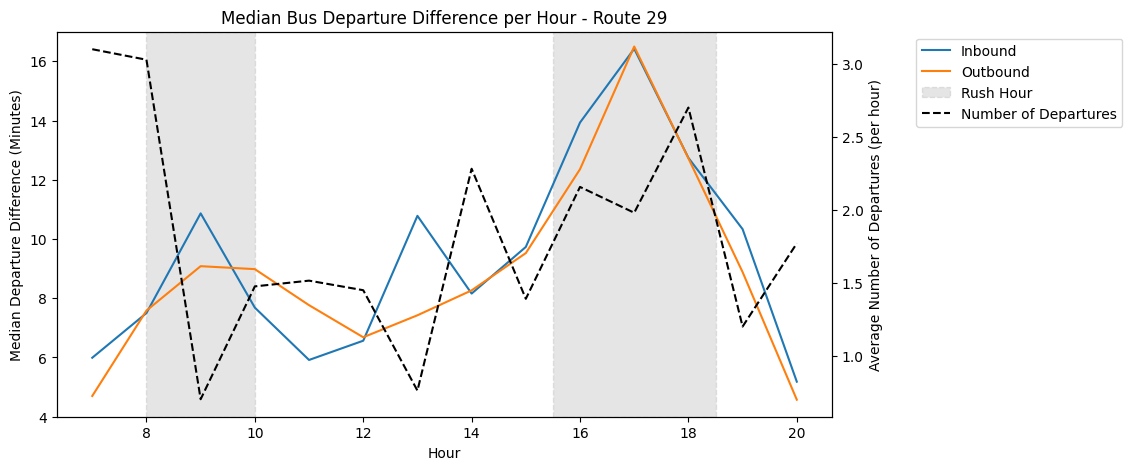

In [121]:
fig,axs = plt.subplots(ncols=1, figsize = (10,5))
bus_29 = bus_29[(bus_29['scheduled_time'] > pd.to_datetime('07:30:00',format = '%H:%M:%S').time())&(bus_29['scheduled_time'] < pd.to_datetime('21:00:00', format ='%H:%M:%S').time())]
bus_29['hour'] = bus_29['scheduled_time'].apply(lambda x: x.hour)
bus_29['is_weekend'] = bus_29['service_date'].apply(lambda x: 1 if pd.to_datetime(x).weekday() > 4 else 0)
sns.lineplot(data = bus_29.groupby(['hour', 'direction_id'])['time_diff'].median().to_frame(), x = 'hour', y = 'time_diff', hue = 'direction_id', ax=axs)

axs.axvspan(8,10, linestyle = '--', color = 'grey', alpha = 0.2, label = 'Rush Hour')
axs.axvspan(15.5,18.5, linestyle = '--', color = 'grey', alpha = 0.2)
axs.axhline(20,linestyle = '--', color = 'black', label = 'Number of Departures')
axs.set_title('Median Bus Departure Difference per Hour - Route 29')
axs.set_ylabel('Median Departure Difference (Minutes)')
axs.set_xlabel('Hour')
axs.legend(loc = 'upper left', bbox_to_anchor=(1.1, 1))
axs.set_ylim(4,17)



time_29 = bus_29.groupby(['hour'])['time_diff'].agg(['mean','median', 'std', 'count']).reset_index()
time_29.columns = ['hour', 'mean', 'median', 'std', 'count']
count_trips = bus_29.groupby('half_trip_id')['hour'].min().reset_index()
count_trips = count_trips.groupby('hour')['half_trip_id'].count().to_frame().reset_index()
count_trips.columns = ['hour', 'count']
count_trips['count'] = count_trips['count']/ bus_29['service_date'].nunique()



ax2 = axs.twinx()
sns.lineplot(ax = ax2, data = count_trips, x = 'hour', y = 'count', linestyle = '--', color = 'black')

ax2.set_ylabel('Average Number of Departures (per hour)')



Text(0.5, 0, 'Hour')

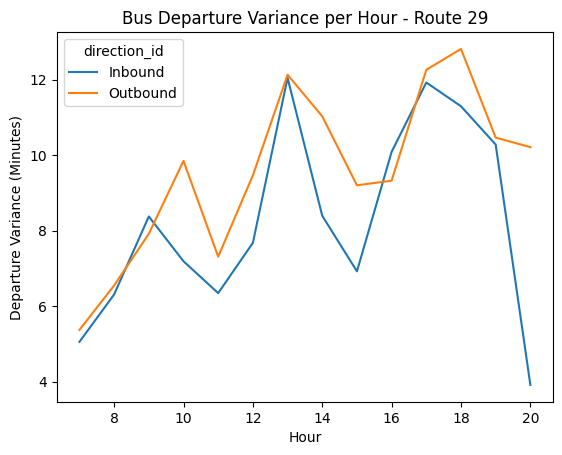

In [122]:
sns.lineplot(data = bus_29.groupby(['hour', 'direction_id'])['time_diff'].std().to_frame(), x = 'hour', y = 'time_diff', hue = 'direction_id')
plt.title('Bus Departure Variance per Hour - Route 29')
plt.ylabel('Departure Variance (Minutes)')
plt.xlabel('Hour')

Text(0.5, 0, '')

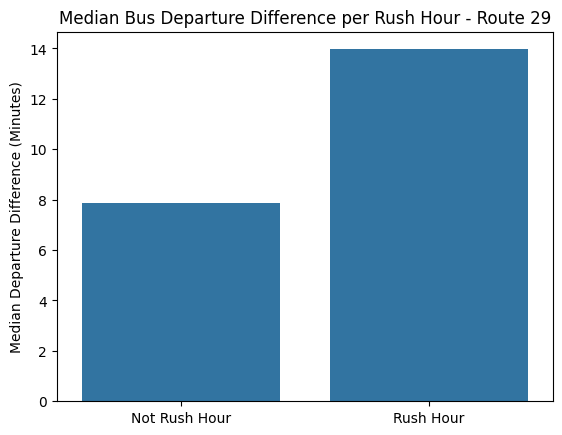

In [124]:

rush_hour = (16,17,18)
bus_29['rush_hour'] = bus_29['hour'].apply(lambda x: 1 if x in rush_hour else 0)
rush_hour_29 = bus_29.groupby('rush_hour')['time_diff'].median().reset_index()
rush_hour_29['rush_hour']=rush_hour_29['rush_hour'].map({0: 'Not Rush Hour', 1: 'Rush Hour'})
sns.barplot(data = rush_hour_29, x = 'rush_hour', y = 'time_diff')
plt.title('Median Bus Departure Difference per Rush Hour - Route 29')
plt.ylabel('Median Departure Difference (Minutes)')
plt.xlabel('')

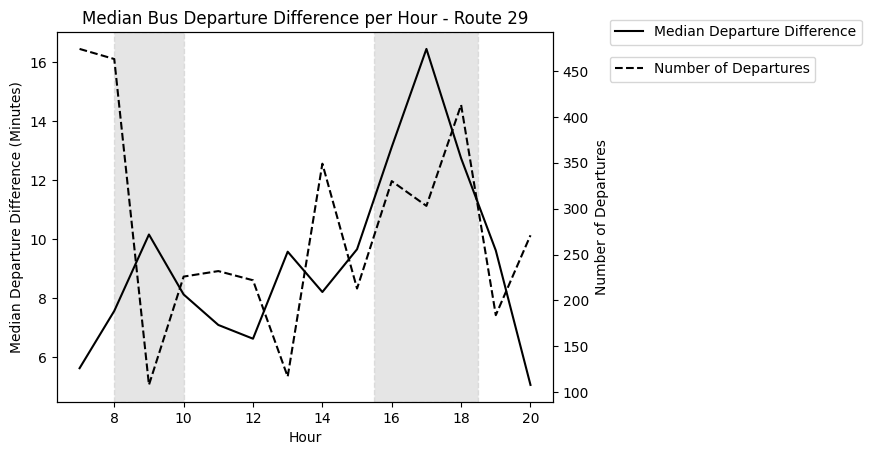

In [125]:
time_29 = bus_29.groupby(['hour'])['time_diff'].agg(['mean','median', 'std', 'count']).reset_index()
time_29.columns = ['hour', 'mean', 'median', 'std', 'count']
count_trips = bus_29.groupby('half_trip_id')['hour'].min().reset_index()
count_trips = count_trips.groupby('hour')['half_trip_id'].count().to_frame().reset_index()
count_trips.columns = ['hour', 'count']
fig, ax = plt.subplots()
sns.lineplot(ax = ax, data = time_29, x = 'hour', y = 'median', color = 'black', label = 'Median Departure Difference')
ax2 = ax.twinx()
sns.lineplot(ax = ax2, data = count_trips, x = 'hour', y = 'count', linestyle = '--', color = 'black', label = 'Number of Departures')
ax.set_title('Median Bus Departure Difference per Hour - Route 29')
ax.set_ylabel('Median Departure Difference (Minutes)')
ax.set_xlabel('Hour')
ax2.set_ylabel('Number of Departures')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.9))
ax.axvspan(8,10, linestyle = '--', color = 'grey', alpha = 0.2, label = 'Rush Hour')
ax.axvspan(15.5,18.5, linestyle = '--', color = 'grey', alpha = 0.2)

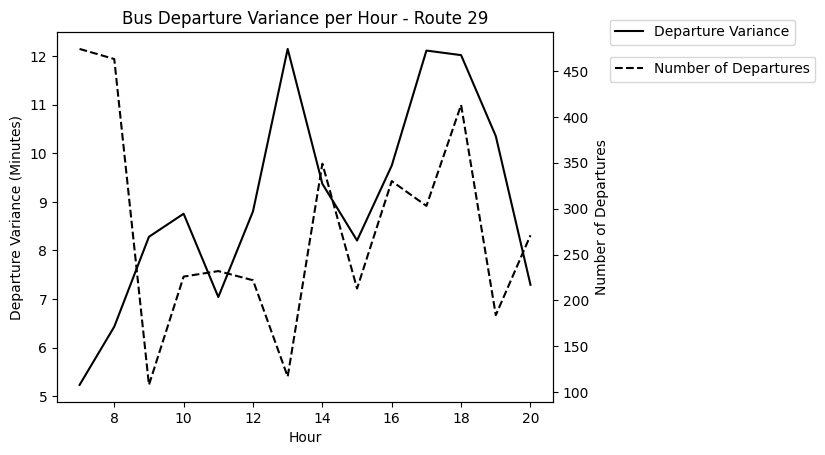

In [126]:
time_29 = bus_29.groupby(['hour'])['time_diff'].agg(['mean','median', 'std', 'count']).reset_index()
time_29.columns = ['hour', 'mean', 'median', 'std', 'count']
count_trips = bus_29.groupby('half_trip_id')['hour'].min().reset_index()
count_trips = count_trips.groupby('hour')['half_trip_id'].count().to_frame().reset_index()
count_trips.columns = ['hour', 'count']
fig, ax = plt.subplots()
sns.lineplot(ax = ax, data = time_29, x = 'hour', y = 'std', color = 'black', label = 'Departure Variance')
ax2 = ax.twinx()
sns.lineplot(ax = ax2, data = count_trips, x = 'hour', y = 'count', linestyle = '--', color = 'black', label = 'Number of Departures')
ax.set_title('Bus Departure Variance per Hour - Route 29')
ax.set_ylabel('Departure Variance (Minutes)')
ax.set_xlabel('Hour')
ax2.set_ylabel('Number of Departures')
ax.legend(loc='center left', bbox_to_anchor=(1.1, 1))
ax2.legend(loc='center left', bbox_to_anchor=(1.1, 0.9))

**Investigating Route 245**

In [127]:
bus_schedule_route_245 = bus_schedule_route[bus_schedule_route['route_id'] == '245']
bus_schedule_stop_245 = bus_schedule_route_stop[bus_schedule_route_stop['route_id'] == '245']
bus_245 = bus_standard_schedule[bus_standard_schedule['route_id'] == '245']
bus_schedule_route_245.head()

,route_id,direction_id,mean,median,std,max,min,count,route_name,route_long_name,route_desc
96,245,Outbound,10.605902,7.583333,10.159615,66.283333,0.000000,4744,245 Outbound,Quincy Center Station - Mattapan Station,Local Bus
95,245,Inbound,9.439876,7.166667,7.959193,58.383333,0.016667,4911,245 Inbound,Quincy Center Station - Mattapan Station,Local Bus


In [128]:
bus_245.head()

,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,actual,scheduled_headway,headway,time_diff,headway_diff,scheduled_time,stop_name,stop_lat,stop_lon
72547,2024-01-02,245,Inbound,61837912,32001,qnctr,1,Startpoint,Schedule,1900-01-01 06:45:00,1900-01-01 06:50:16,NaN,NaN,5.266667,NaN,06:45:00,Quincy Center,42.251696,-71.004973
72548,2024-01-02,245,Inbound,61837912,3093,aleyn,2,Midpoint,Schedule,1900-01-01 06:46:00,1900-01-01 06:50:53,NaN,NaN,4.883333,NaN,06:46:00,Adams St @ Alleyne St,42.255834,-71.008657
72549,2024-01-02,245,Inbound,61837912,13406,pckrd,3,Midpoint,Schedule,1900-01-01 06:50:00,1900-01-01 06:55:46,NaN,NaN,5.766667,NaN,06:50:00,Granite St @ Packards Lane,42.244425,-71.010311
72550,2024-01-02,245,Inbound,61837912,3359,emlsq,4,Midpoint,Schedule,1900-01-01 06:56:00,1900-01-01 07:02:21,NaN,NaN,6.350000,NaN,06:56:00,Adams St @ Church St,42.257950,-71.039279
72551,2024-01-02,245,Inbound,61837912,4344,rdran,5,Midpoint,Schedule,1900-01-01 07:02:00,1900-01-01 07:08:24,NaN,NaN,6.400000,NaN,07:02:00,Reedsdale Rd @ Randolph Ave,42.248574,-71.069046


In [129]:
bus_245.groupby(['stop_id', 'stop_name','direction_id'])['time_diff'].count()/bus_245['service_date'].nunique()

stop_id  stop_name                               direction_id
13406    Granite St @ Packards Lane              Inbound         4.688
185      Mattapan                                Inbound         4.744
                                                 Outbound        4.720
23406    Granite St @ Packards Lane              Outbound        4.656
3031     Hancock St @ Saint Anns Rd              Inbound         0.856
3036     Hancock St opp Greenleaf St             Outbound        0.872
3093     Adams St @ Alleyne St                   Inbound         4.696
3191     Newport Ave @ Beale St                  Inbound         0.832
3199     Adams St opp Alleyne St                 Outbound        4.552
32001    Quincy Center                           Inbound         4.720
                                                 Outbound        4.344
3359     Adams St @ Church St                    Inbound         4.712
3391     Adams St @ Mechanic St                  Outbound        4.696
4144     Reedsdale Rd @ Central Ave              Outbound        4.704
4147     Opp 202 Reedsdale Rd @ MIlton Hospital  Outbound        4.720
4198     Reedsdale Rd @ Meredith Cir             Inbound         4.688
4344     Reedsdale Rd @ Randolph Ave             Inbound         4.688
4364     Reedsdale Rd @ Randolph Ave             Outbound        4.688
4404     Brook Rd @ Central Ave                  Inbound         4.664
Name: time_diff, dtype: float64

In [130]:
fig = px.scatter_mapbox(bus_schedule_stop_245, lat="stop_lat", lon="stop_lon",
                        zoom=12,
                        size = 'median',
                        #color_continuous_scale=px.colors.sequential.amp,
                        color="direction_id",
                        mapbox_style = 'basic',
                        title = 'Median Bus Departure Difference per Station & Route - Headway',
                        labels = {'median':'Median Departure Difference (Minutes)',
                                  'direction_id': 'Direction',
                                  'stop_name': 'Stop',
                                  'route_id': 'Route'},
                        hover_data = ['direction_id', 'stop_name', 'route_id'],

                        #symbol = 'direction_id',

                        width = 1000,
                        height = 800
)
fig.update_layout(
    title_x=0.5,
    title_y=0.9,
    title_font_size=24,
    legend_x = 0,
    legend_y = 1
)

Text(0.5, 1.0, 'Mean Bus Departure Difference per Direction - Route 245')

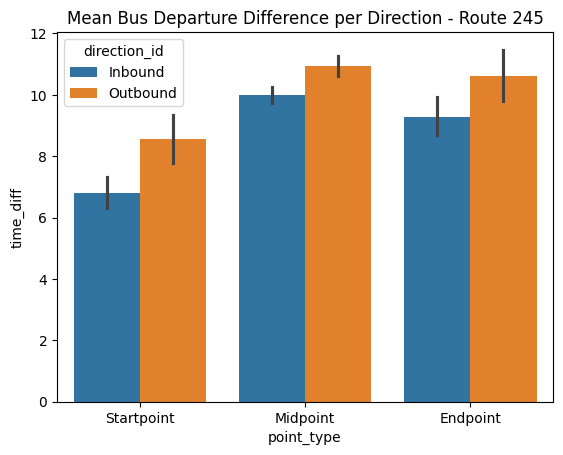

In [131]:
sns.barplot(data = bus_245, y = 'time_diff', x = 'point_type', hue = 'direction_id')
plt.title('Mean Bus Departure Difference per Direction - Route 245')

Text(0.5, 0, 'Stop Number')

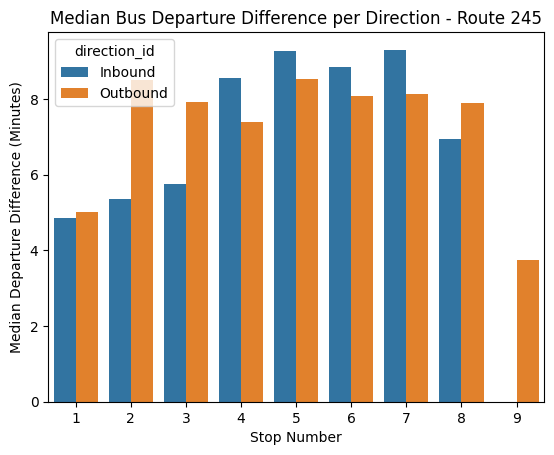

In [132]:
sns.barplot(data = bus_245.groupby(['time_point_order', 'direction_id'])['time_diff'].median().to_frame().reset_index(), y = 'time_diff', x = 'time_point_order', hue = 'direction_id')
plt.title('Median Bus Departure Difference per Direction - Route 245')
plt.ylabel('Median Departure Difference (Minutes)')
plt.xlabel('Stop Number')

In [144]:
bus_245_start_comp = bus_245[bus_245['point_type'] != 'Midpoint'].sort_values(by = ['service_date', 'scheduled_time'])
bus_245_start_comp['prev_id'] = bus_245_start_comp['stop_id'].shift(1)
bus_245_start_comp['prev_arrive_early'] = bus_245_start_comp['scheduled'] - bus_245_start_comp['actual'].shift(1) #Get time between end point and start point, limited to same stop
bus_245_start_comp['prev_arrive_early_time'] = bus_245_start_comp['prev_arrive_early'].apply(lambda x: x.total_seconds())/60
bus_245_start_comp['prev_arrive_early'] = bus_245_start_comp['prev_arrive_early_time'].apply(lambda x: 0 if x<3 else 1)
bus_245_start_comp['is_last_yest'] = bus_245_start_comp['service_date'].shift(1)
bus_245_start_comp['is_last_yest'] = (bus_245_start_comp['service_date'] != bus_245_start_comp['is_last_yest'])
bus_245_start_comp['prev_arrive_early'] = bus_245_start_comp.apply(lambda x: 1 if (x['is_last_yest'] == True) else x['prev_arrive_early'], axis = 1)
bus_245_start_comp=bus_245_start_comp[bus_245_start_comp['point_type'] == 'Startpoint'] #Only Capture Start times

In [145]:
bus_245_start_comp_out = bus_245_start_comp.groupby(['prev_arrive_early', 'direction_id'])['time_diff'].agg(['mean', 'median','min', 'max', 'std', 'count']).reset_index()
bus_245_start_comp_out['prev_arrive_early'] = bus_245_start_comp_out['prev_arrive_early'].map({0: 'No', 1: 'Yes'})
bus_245_start_comp_out['count_pct'] = bus_245_start_comp_out['count']/bus_245[bus_245['point_type'] == 'Startpoint']['time_diff'].count()
bus_245_start_comp_out

,prev_arrive_early,direction_id,mean,median,min,max,std,count,count_pct
0,No,Inbound,12.686185,10.466667,0.250000,51.950000,8.773540,187,0.145299
1,No,Outbound,9.908151,6.433333,0.000000,56.633333,9.983204,503,0.390831
2,Yes,Inbound,4.624477,3.966667,0.016667,32.233333,3.903676,510,0.396270
3,Yes,Outbound,0.766858,0.483333,0.016667,9.883333,1.165851,87,0.067599


Text(0.5, 0, 'Did Incoming Bus Arrive Early?')

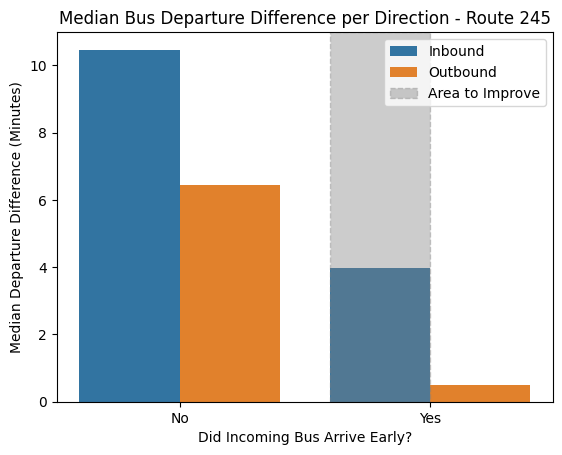

In [146]:
sns.barplot(data = bus_245_start_comp_out, y = 'median', x = 'prev_arrive_early', hue = 'direction_id')
plt.axvspan(0.6,1, linestyle = '--', color = 'grey', alpha = 0.4, label = 'Area to Improve')
plt.legend(loc = 'upper right')
plt.title('Median Bus Departure Difference per Direction - Route 245')
plt.ylabel('Median Departure Difference (Minutes)')
plt.xlabel('Did Incoming Bus Arrive Early?')

<ipython-input-147-e603657d41c3>:8: UserWarning:

FixedFormatter should only be used together with FixedLocator



Text(0.5, 0, 'Did Incoming Bus Arrive Early?')

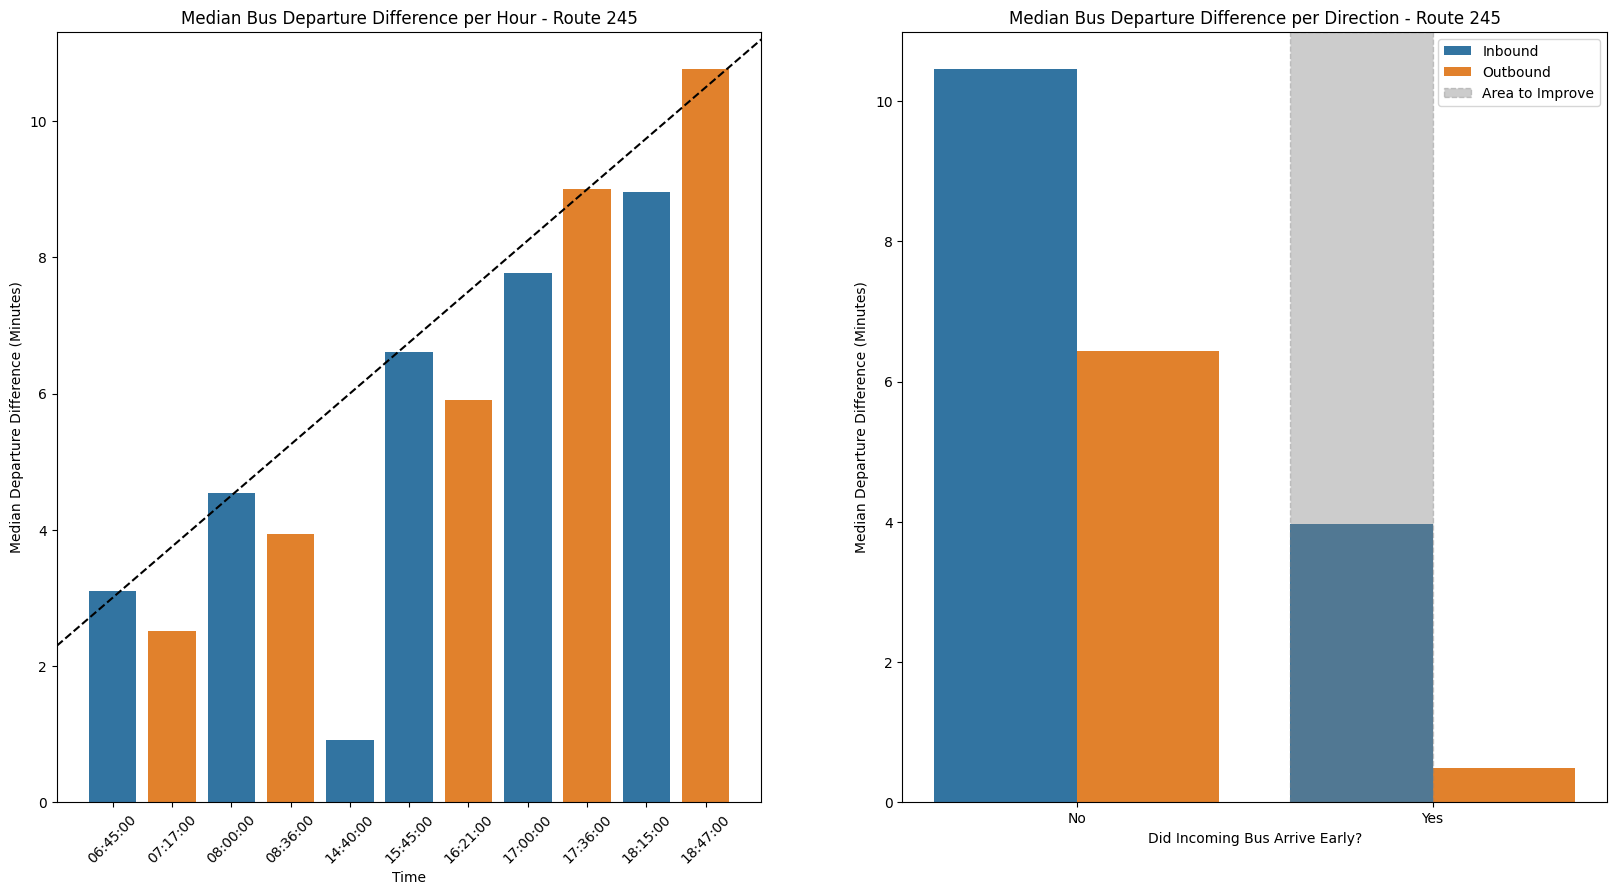

In [147]:
fig,axs = plt.subplots(ncols=2, figsize = (20,10))
time_245 = bus_245[bus_245['time_point_order'] == 1].groupby(['scheduled_time', 'stop_name', 'direction_id'])['time_diff'].agg(['mean', 'median','min', 'max', 'std', 'count']).reset_index()
sns.barplot(data = time_245, x = 'scheduled_time', y = 'median', hue = 'direction_id', ax=axs[0], legend = False)
axs[0].axline(slope = 0.75, xy1 = (0,3), color = 'black', linestyle = '--', label = 'Trend')
axs[0].set_title('Median Bus Departure Difference per Hour - Route 245')
axs[0].set_ylabel('Median Departure Difference (Minutes)')
axs[0].set_xlabel('Time')
axs[0].set_xticklabels(axs[0].get_xticklabels(), rotation = 45)

sns.barplot(data = bus_245_start_comp_out, y = 'median', x = 'prev_arrive_early', hue = 'direction_id', ax=axs[1])

axs[1].axvspan(0.6,1, linestyle = '--', color = 'grey', alpha = 0.4, label = 'Area to Improve')
axs[1].legend(loc = 'upper right')
axs[1].set_title('Median Bus Departure Difference per Direction - Route 245')
axs[1].set_ylabel('Median Departure Difference (Minutes)')
axs[1].set_xlabel('Did Incoming Bus Arrive Early?')

In [148]:
bus_245_start_comp['hour'] = bus_245_start_comp['scheduled_time'].apply(lambda x: x.hour)
bus_245_start_comp['month'] = bus_245_start_comp['service_date'].apply(lambda x: x.split('-')[1])
bus_245_start_comp['prev_arrive_early'] = bus_245_start_comp['prev_arrive_early'].map({0: 'No', 1: 'Yes'})
bus_245_start_comp.head(50)

,service_date,route_id,direction_id,half_trip_id,stop_id,time_point_id,time_point_order,point_type,standard_type,scheduled,...,scheduled_time,stop_name,stop_lat,stop_lon,month,prev_id,prev_arrive_early,prev_arrive_early_time,is_last_yest,hour
72547,2024-01-02,245,Inbound,61837912,32001,qnctr,1,Startpoint,Schedule,1900-01-01 06:45:00,...,06:45:00,Quincy Center,42.251696,-71.004973,01,None,Yes,NaN,True,6
72589,2024-01-02,245,Outbound,61837913,185,matpn,1,Startpoint,Schedule,1900-01-01 07:17:00,...,07:17:00,Mattapan,42.267715,-71.092067,01,185,No,0.566667,False,7
72555,2024-01-02,245,Inbound,61837914,32001,qnctr,1,Startpoint,Schedule,1900-01-01 08:00:00,...,08:00:00,Quincy Center,42.251696,-71.004973,01,32001,Yes,10.000000,False,8
72598,2024-01-02,245,Outbound,61837915,185,matpn,1,Startpoint,Schedule,1900-01-01 08:36:00,...,08:36:00,Mattapan,42.267715,-71.092067,01,185,Yes,3.383333,False,8
72563,2024-01-02,245,Inbound,61837142,3031,hnann,1,Startpoint,Schedule,1900-01-01 14:40:00,...,14:40:00,Hancock St @ Saint Anns Rd,42.261229,-71.011256,01,32001,Yes,332.116667,False,14
72565,2024-01-02,245,Inbound,61837916,32001,qnctr,1,Startpoint,Schedule,1900-01-01 15:45:00,...,15:45:00,Quincy Center,42.251696,-71.004973,01,3191,Yes,47.050000,False,15
72606,2024-01-02,245,Outbound,61837917,185,matpn,1,Startpoint,Schedule,1900-01-01 16:21:00,...,16:21:00,Mattapan,42.267715,-71.092067,01,185,Yes,5.583333,False,16
72573,2024-01-02,245,Inbound,61837918,32001,qnctr,1,Startpoint,Schedule,1900-01-01 17:00:00,...,17:00:00,Quincy Center,42.251696,-71.004973,01,32001,Yes,4.100000,False,17
72614,2024-01-02,245,Outbound,61837919,185,matpn,1,Startpoint,Schedule,1900-01-01 17:36:00,...,17:36:00,Mattapan,42.267715,-71.092067,01,185,Yes,4.383333,False,17
72581,2024-01-02,245,Inbound,61837920,32001,qnctr,1,Startpoint,Schedule,1900-01-01 18:15:00,...,18:15:00,Quincy Center,42.251696,-71.004973,01,32001,Yes,14.833333,False,18


Text(0.5, 0, 'Hour')

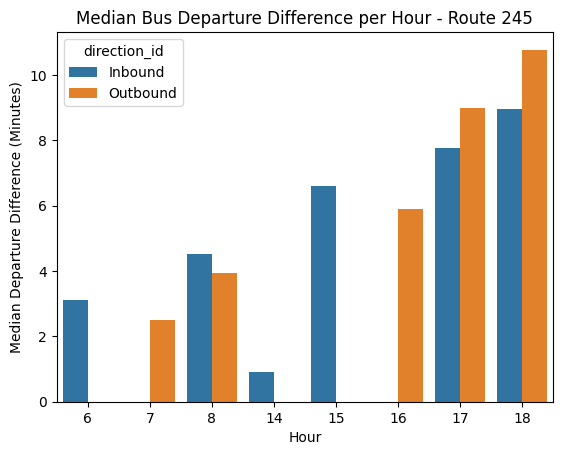

In [149]:
barplot_245 = bus_245_start_comp.groupby(['hour', 'direction_id'])['time_diff'].agg('median').reset_index()
sns.barplot(data =barplot_245 , x = 'hour', y = 'time_diff', hue = 'direction_id')
plt.title('Median Bus Departure Difference per Hour - Route 245')
plt.ylabel('Median Departure Difference (Minutes)')
plt.xlabel('Hour')

Text(0.5, 0, 'Hour')

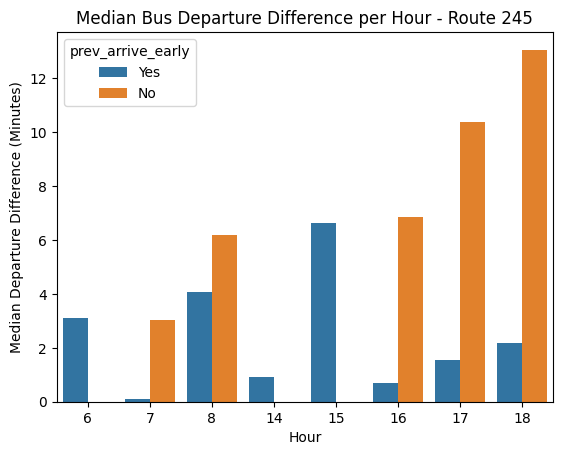

In [150]:
lineplot_245 = bus_245_start_comp.groupby(['hour', 'prev_arrive_early'])['time_diff'].agg('median').reset_index()
sns.barplot(data =lineplot_245 , x = 'hour', y = 'time_diff', hue = 'prev_arrive_early')
plt.title('Median Bus Departure Difference per Hour - Route 245')
plt.ylabel('Median Departure Difference (Minutes)')
plt.xlabel('Hour')

<ipython-input-151-7fcbccfd5857>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



Text(0, 0.5, 'Median Departure Difference (Minutes)')

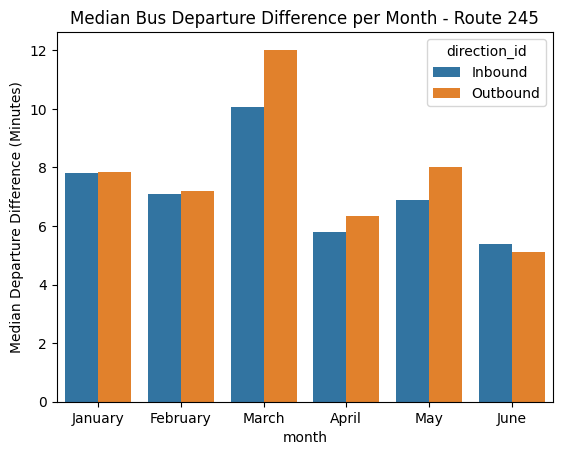

In [151]:
import calendar
bus_245['month'] = bus_245['service_date'].apply(lambda x: x.split('-')[1])
month_245 = bus_245.groupby(['month', 'direction_id'])['time_diff'].agg(['mean', 'median','min', 'max', 'std', 'count']).reset_index()
month_245.columns = ['month', 'direction_id', 'mean', 'median', 'min', 'max', 'std', 'count']
month_245['month'] = month_245['month'].apply(lambda x: calendar.month_name[int(x)])

sns.barplot(data = month_245, y = 'median', x = 'month', hue = 'direction_id')
plt.title('Median Bus Departure Difference per Month - Route 245')
plt.ylabel('Median Departure Difference (Minutes)')

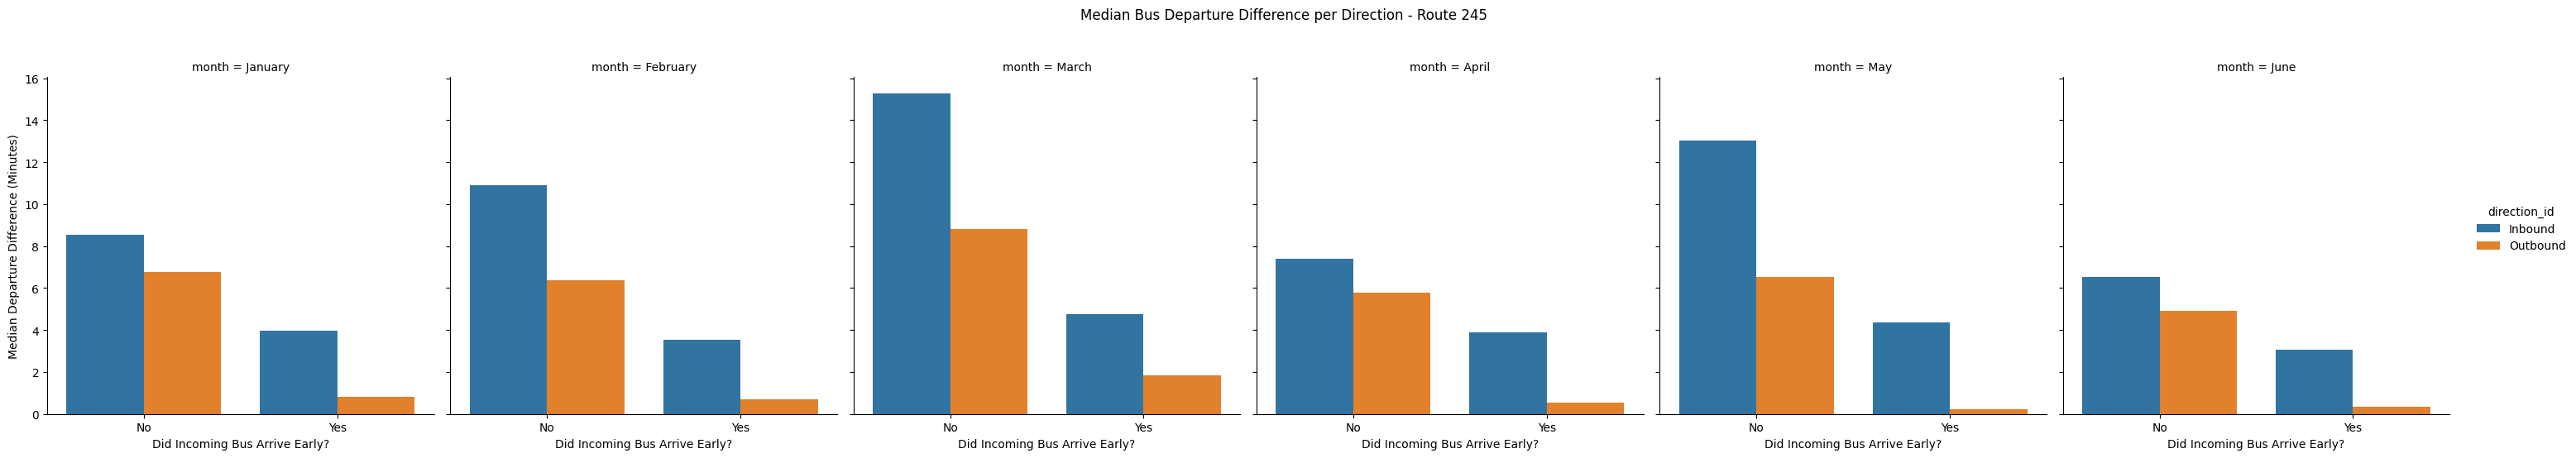

In [152]:
bus_245_start_comp_out = bus_245_start_comp.groupby(['prev_arrive_early', 'direction_id', 'month'])['time_diff'].agg(['mean', 'median','min', 'max', 'std', 'count']).reset_index()
bus_245_start_comp_out['count_pct'] = bus_245_start_comp_out['count']/bus_245[bus_245['point_type'] == 'Startpoint']['time_diff'].count()
bus_245_start_comp_out['month'] = bus_245_start_comp_out['month'].apply(lambda x: calendar.month_name[int(x)])



g = sns.catplot(data = bus_245_start_comp_out, y = 'median', x = 'prev_arrive_early', hue = 'direction_id', col = 'month', kind = 'bar')
g.fig.suptitle('Median Bus Departure Difference per Direction - Route 245', y = 1.1)
g.set_ylabels('Median Departure Difference (Minutes)')
g.set_xlabels('Did Incoming Bus Arrive Early?')

<ipython-input-177-4ef023ce08c7>:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-177-4ef023ce08c7>:2: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

<ipython-input-177-4ef023ce08c7>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



(0.0, 13.0)

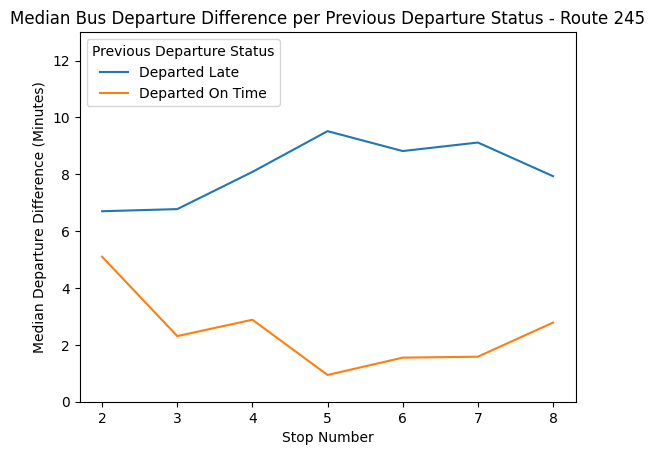

In [177]:
bus_245['prev_late'] = (bus_245.groupby(['service_date', 'half_trip_id'])['scheduled'].shift(1)) - (bus_245.groupby(['service_date', 'half_trip_id'])['actual'].shift(1))
bus_245['prev_late'] = (bus_245['prev_late'].apply(lambda x: x.total_seconds())/60).apply(lambda x: 1 if x <0 else 0)
bus_245['prev_late'] = bus_245['prev_late'].map({0: 'Departed On Time', 1: 'Departed Late'})
fig,axs = plt.subplots()
early_group = bus_245[bus_245['point_type'] != 'Startpoint'].groupby(['prev_late','time_point_order'])['time_diff'].agg(['mean', 'median','min', 'max', 'std', 'count']).reset_index()
early_group = early_group[early_group['time_point_order'] < 9]
sns.lineplot(data = early_group, x = 'time_point_order', y = 'median', hue = 'prev_late', ax=axs)
axs.set_title('Median Bus Departure Difference per Previous Departure Status - Route 245')
axs.set_ylabel('Median Departure Difference (Minutes)')
axs.set_xlabel('Stop Number')
axs.legend(loc = 'upper left', title = 'Previous Departure Status')
axs.set_ylim(0,13)

Text(0.5, 0, 'Did Incoming Bus Arrive Early')

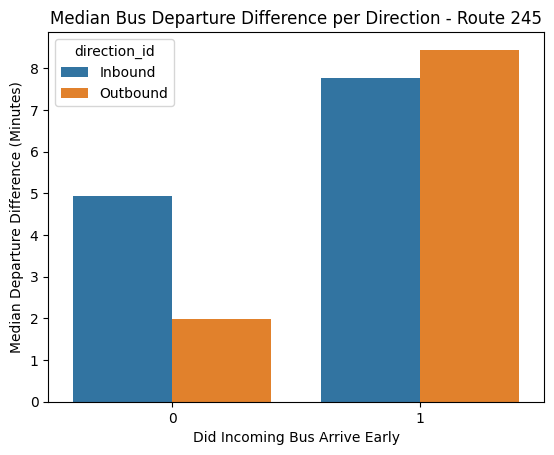

In [166]:
early_group = bus_245[bus_245['point_type'] != 'Startpoint'].groupby(['prev_late', 'direction_id'])['time_diff'].agg(['mean', 'median','min', 'max', 'std', 'count']).reset_index()
sns.barplot(data = early_group, x = 'prev_late', y = 'median', hue = 'direction_id')
plt.title('Median Bus Departure Difference per Direction - Route 245')
plt.ylabel('Median Departure Difference (Minutes)')
plt.xlabel('Did Incoming Bus Arrive Early')